# High-order Kalman filter

## Introduction
This notebook shows the difference between a high-order Kalman filter, the matrix of which is calculated using the output published in the article [], and a 2-order filter in the presence of gaps in the signal.

Table of contents:
- [Introduction](#introduction)
- [Importing libraries](#importing-libraries)
- [Generating data](#generating-data)
- [Plotting data](#plotting-data)
- [Calculating filters for the generated signal](#calculating-filters)
- [Restoring the signal](#restoring-the-signal)
- [Results](#conclusion)



## Importing libraries

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt

from StatTools.generators.kasdin_generator import KasdinGenerator
from StatTools.filters.kalman_filter import EnhancedKalmanFilter
from StatTools.analysis.dfa import DFA

## Generating data

In [26]:
def add_poisson_gaps(trajectory, gap_rate, length_rate):
    """
    Adds gaps to the trajectory according to the Poisson flow.

    Parameters:
    - trajectory: np.array, initial trajectory
    - gap_rate: parameter for the Poisson flow of gaps (the more, the more frequent the gaps)
    - length_rate: parameter for the Poisson distribution of gap lengths

    Returns:
    - trajectory_with_gaps: np.array, trajectory with gaps
    - gap_indices: list of tuples (start, end) of missed intervals
    """
    n = len(trajectory)
    trajectory_with_gaps = trajectory.copy()
    gap_indices = []

    current_pos = 0
    while current_pos < n:
        interval = np.random.exponential(1 / gap_rate)
        current_pos += int(interval)

        if current_pos >= n:
            break

        length = np.random.poisson(length_rate)
        if length <= 0:
            length = 1

        end_pos = min(current_pos + length, n)

        trajectory_with_gaps[current_pos:end_pos] = np.nan
        gap_indices.append((current_pos, end_pos))

        current_pos = end_pos

    return trajectory_with_gaps, gap_indices

In [27]:
h = 0.8
TRJ_LEN = 2**12

In [28]:
generator = KasdinGenerator(h, length=TRJ_LEN)
generated_signal = generator.get_full_sequence()
gaps_signal, gaps = add_poisson_gaps(generated_signal, 0.2, 2.0)

## Plotting data

In [29]:
axis_fontsize = 14
label_fontsize = 14
legend_fontsize = 14
title_fontsize = 16

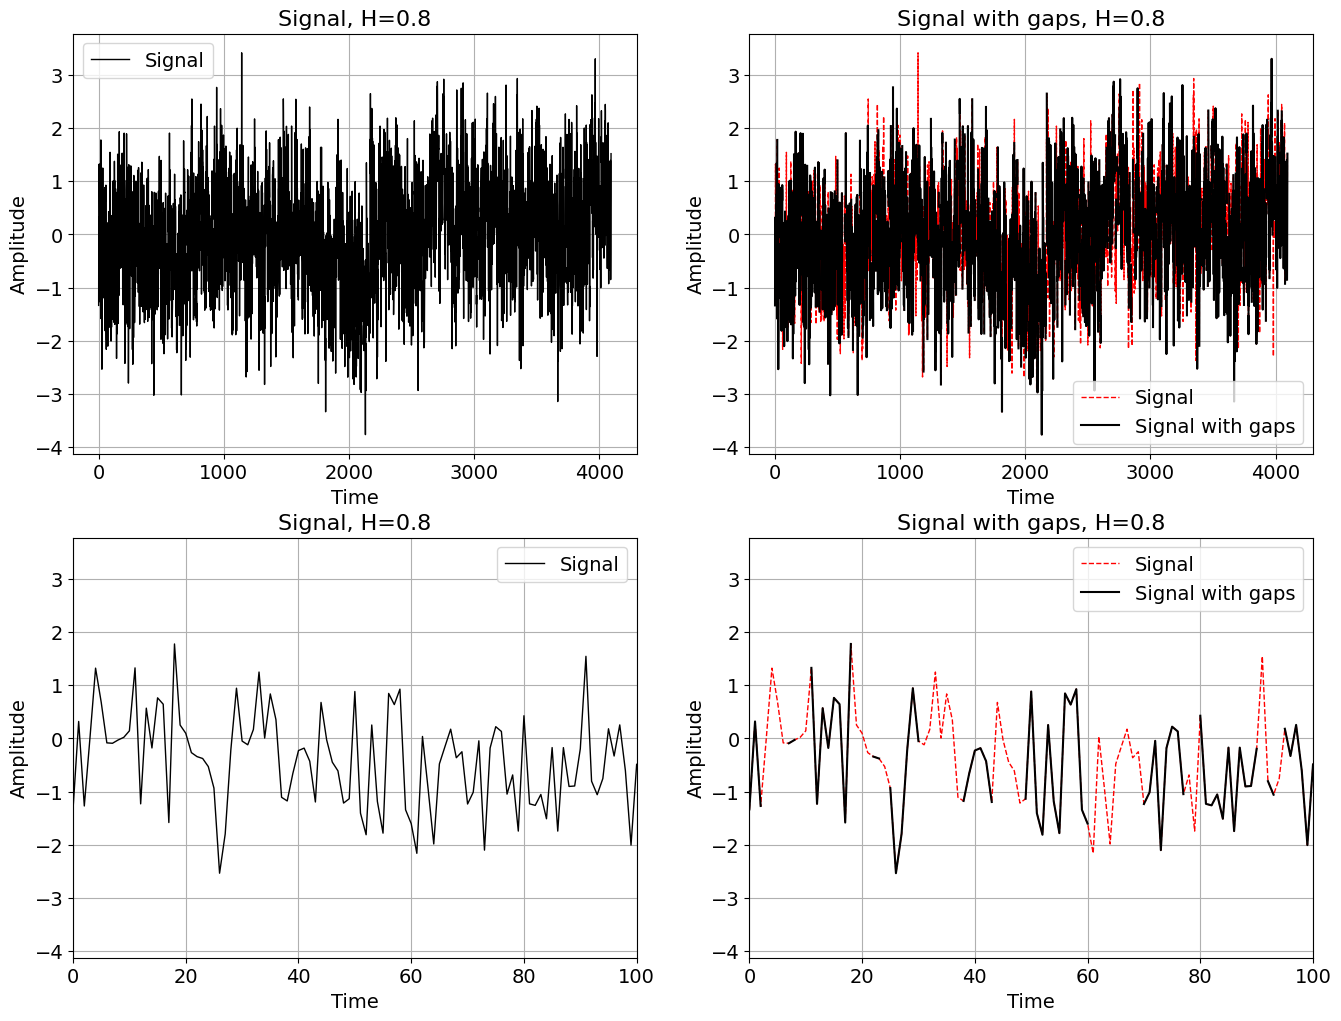

In [30]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 2, 1)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 2)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 3)
plt.plot(generated_signal, label="Signal", color="black", linewidth=1)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.xlim(0, 100)
plt.grid(True)
plt.title(f"Signal, H={h}", fontdict={"fontsize": title_fontsize})

plt.subplot(2, 2, 4)
plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black")
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.xlim(0, 100)
plt.title(f"Signal with gaps, H={h}", fontdict={"fontsize": title_fontsize})
plt.show()


## Calculating filters for the generated signal

Init filters and configure them with the generated signala nd noise. 

(Note that we have the signal with gaps noise is not used in the filter and equal to None)

In [31]:
noise = np.zeros(TRJ_LEN)

second_order_filter = EnhancedKalmanFilter(dim_x=2, dim_z=1)
second_order_filter.auto_configure(generated_signal, noise)

third_order_filter = EnhancedKalmanFilter(dim_x=3, dim_z=1)
third_order_filter.auto_configure(generated_signal, noise)

high_order_filter = EnhancedKalmanFilter(dim_x=7, dim_z=1)
high_order_filter.auto_configure(generated_signal, noise)

## Restoring the signal

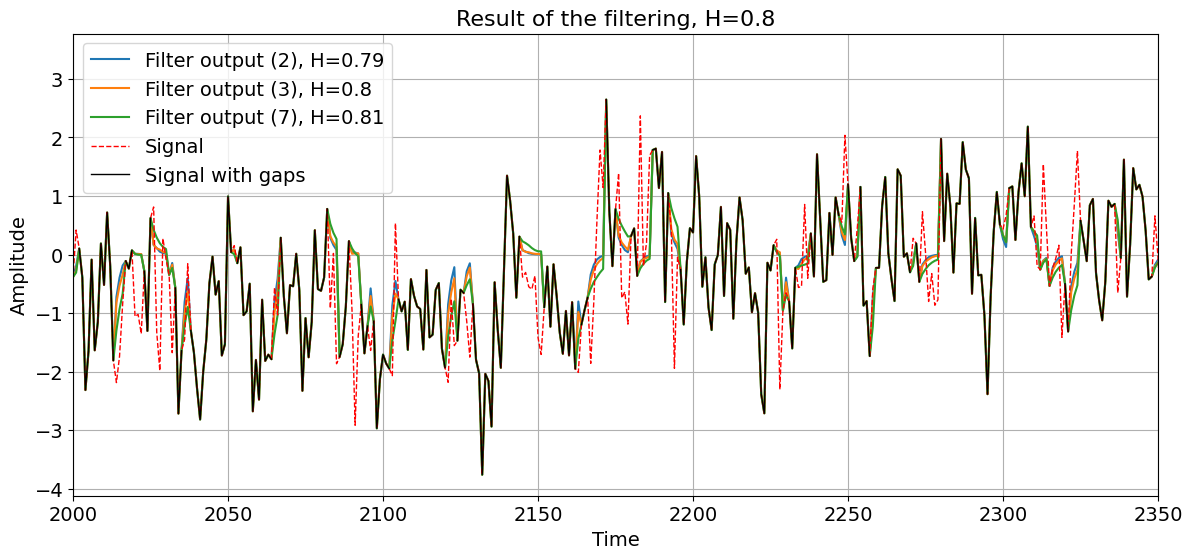

In [32]:
plt.figure(figsize=(14, 6))
for f in [second_order_filter, third_order_filter, high_order_filter]:
    recovered_signal = np.zeros(TRJ_LEN)
    for k in range(1, TRJ_LEN):
        f.predict()
        if not np.isnan(gaps_signal[k]):
            f.update(gaps_signal[k])
        recovered_signal[k] = f.x[0].item()
    dfa = DFA(recovered_signal)
    rec_h = dfa.find_h()
    plt.plot(recovered_signal, label=f"Filter output ({f.dim_x}), H={round(rec_h, 2)}")

plt.plot(
    generated_signal,
    label="Signal",
    color="red",
    linestyle="--",
    linewidth=1,
)
plt.plot(gaps_signal, label="Signal with gaps", color="black", linewidth=1)
plt.xlim(2000, 2350)
plt.xlabel("Time", fontsize=axis_fontsize)
plt.ylabel("Amplitude", fontsize=axis_fontsize)
plt.legend(fontsize=legend_fontsize)
plt.tick_params(labelsize=label_fontsize)
plt.grid(True)
plt.title(f"Result of the filtering, H={h}", fontdict={"fontsize": title_fontsize})
plt.show()

## Results